# set up environment

In [7]:
import math
# ------------------------------
import numpy as np
import numpy.random as rand
# ------------------------------
import scipy.stats as stats
from scipy.interpolate import Rbf
# ------------------------------
from sklearn.datasets import make_blobs
# ------------------------------
from numba import cuda, vectorize
# ------------------------------
import umap
# ------------------------------
import matplotlib.pyplot as plt

In [14]:
# Import the path of function
import sys
import importlib
sys.path.append('/local_data/notebooks/clintko/GitRepo/Proj_SingleCell/Test Func')

# Import tool of flow to image
import Tool_flow2img
importlib.reload(Tool_flow2img)
from Tool_flow2img import *

In [2]:
head = lambda x: x[0:6]
tail = lambda x: x[-6:]
# ------------------------------
point_dtype = np.dtype({
    'names':   ['x', 'y'],
    'formats': [np.float32, np.float32]})

# import data

In [9]:
# input the value
tmp_dir = "/data/deep-learning-group/test_data/flow_EQAPOL/"
fname_Costim = "data_Costim.np"
fname_CMV    = "data_CMV.np"
fname_SEB    = "data_SEB.np"

# open and write the file
print("read Costim")
file_object = open(tmp_dir + fname_Costim, 'rb')
data_Costim = np.load(file_object)
file_object.close()

#print("read CMV")
#file_object = open(tmp_dir + fname_CMV, 'rb')
#data_CMV = np.load(file_object)
#file_object.close()

#print("read SEB")
#file_object = open(tmp_dir + fname_SEB, 'rb')
#data_SEB = np.load(file_object)
#file_object.close()

print("read markers")
file_object = open(tmp_dir + "markers.np", 'rb')
markers = np.load(file_object)
markers_dict = {items[1]: idx for idx, items in enumerate(markers)}
file_object.close()

print("The data are input.")

read Costim
read markers
The data are input.


# define kernels and helper functions

In [177]:
@cuda.jit(device = True)
def dist2_kernel(point1, point2):
    return math.pow(point1["x"] - point2["x"], 2) + math.pow(point1["y"] - point2["y"], 2)

@cuda.jit(device = True)
def dist2weight_kernel(distance_square):
    #if (kernel == "standard normal"):
    return math.exp(-1 * distance_square)

# signature: point_dtype[:], point_dtype[:], float[:, :]
@cuda.jit
def get_weights(grids, points, weights):  
    idx_grid, idx_point = cuda.grid(2)
    if (idx_grid < weights.shape[0]) & (idx_point < weights.shape[1]):
        # intialization
        grid  = grids[idx_grid]
        point = points[idx_point]
        
        # calculate distance and then convert to weights
        dist2 = dist2_kernel(grid, point)
        #x = np.array([grid.x - point.x, grid.y - point.y])
        #x_gpu = gpuarray.to_gpu(x)
        #dist2 = linalg.norm(x_gpu)
        
        weights[idx_grid, idx_point] = dist2weight_kernel(dist2)
        
# helper function
def set_points(dat_pts):
    """Convert data frame of coordinates to an array of points
    
    >>> tmp = np.arange(10).reshape(-1, 2)
    >>> set_points(tmp)
    ... array([(0., 1.), (2., 3.), (4., 5.), (6., 7.), (8., 9.)],
      dtype=[('x', '<f8'), ('y', '<f8')])
    >>> set_points(tmp)[0]['x'], set_points(tmp)[0]['y']
    ... (0.0, 1.0)
    """
    num_pts = dat_pts.shape[0]
    points = np.empty((num_pts,), dtype = point_dtype)
    
    for idx in range(num_pts):
        p = points[idx]
        p['x'], p['y'] = dat_pts[idx][0], dat_pts[idx][1]
    
    return points

In [63]:
def plot_tsne_nocolor(ax, tsne, point_size = 2, alpha = 0.5):
    """plot plain"""
    x   = tsne[:, 0]
    y   = tsne[:, 1]
    ax.scatter(
        x, y, s=point_size, alpha=alpha)
    
def plot_tsne(ax, tsne, sample, idx_feature = 0, n_grid = 128, point_size = 2, alpha = 0.5):
    """plot tsne with color of a feature"""
    x   = tsne[:, 0]
    y   = tsne[:, 1]
    z   = sample[:, idx_feature]
    
    ax.scatter(
        x, y, c = z, 
        s=point_size, alpha=alpha, 
        cmap=plt.get_cmap('Reds'))
    
################################################    
# because the difference of dimension
def plot_img(ax, tsne, img, idx_feature = 0, n_grid = 128, point_size = 2, alpha = 0.5):
    """plot images created from tsne"""
    x   = tsne[:, 0]
    y   = tsne[:, 1]
    x_c = np.linspace(min(x), max(x), n_grid)
    y_c = np.linspace(min(y), max(y), n_grid)
    x_c, y_c = np.meshgrid(x_c, y_c)
    z_c = img[:, :, idx_feature] # z_c = img[idx_feature]
    
    ax.scatter(
        x_c, y_c, c = z_c, 
        s=point_size, alpha=alpha, 
        cmap=plt.get_cmap('Blues'))

# Dimensional reduction to create data points

In [22]:
DIM_GRIDS = 128

In [12]:
data_samples = data_Costim[0:2]
data_labels = [0, 0]

print("===== Raw Shape ======")
print(data_samples.shape)
print(data_samples[0].shape) # Costim
print(data_samples[1].shape) # Costim
#print(data_samples[2].shape) # CMV
#print(data_samples[3].shape) # CMV
#print(data_samples[4].shape) # SEB
#print(data_samples[5].shape) # SEB

===== Raw Shape ======
(2,)
(455472, 14)
(607410, 14)


In [15]:
data_samples_std = data_standardization(data_samples, verbose=True)

Data Standardization...
...Finish


In [16]:
print("===== 10,000 cells ======")
data_labels_sub, data_samples_sub = data_subsetting(
    data_samples_std, 
    data_labels, 
    k = 10000, 
    num_subsets = 2, 
    rand_seed   = 0,
    verbose = True)

print("===== Shape After subsetting ======")
print(data_samples_sub.shape)
print(data_samples_sub[0].shape) # Costim
print(data_samples_sub[1].shape) # Costim

===== 10,000 cells ======
Data Subsetting...
...Finish
===== Shape After subsetting ======
(4, 10000, 14)
(10000, 14)
(10000, 14)


In [17]:
print("===== Dim Reduct ======\n")
data_umap = create_umap(data_samples_sub, verbose = True, rand_seed = 0)

print("===== UMAP Shape ======")
print(data_umap.shape)
print(data_umap[0].shape) # Costim
print(data_umap[1].shape) # Costim

===== Dim Reduct ======

Create UMAP plots...
	Prepare UMAP plot of the 0 sample
	Prepare UMAP plot of the 1 sample
	Prepare UMAP plot of the 2 sample
	Prepare UMAP plot of the 3 sample
...Finish
===== UMAP Shape ======
(4, 10000, 2)
(10000, 2)
(10000, 2)


# set grids

In [31]:
def set_grids(data_samples, dim_grids):
    lst_grids = list()
    for sample in data_samples:
        x = sample[:, 0]
        y = sample[:, 1]
        
        # set up coordinates
        x_c = np.linspace(np.min(x), np.max(x), dim_grids)
        y_c = np.linspace(np.min(y), np.max(y), dim_grids)
        x_c, y_c = np.meshgrid(x_c, y_c)
        
        dat_grids = np.array([x_c.ravel(), y_c.ravel()])
        dat_grids = dat_grids.T
        grids = set_points(dat_grids)
        lst_grids.append(grids)    
    return lst_grids

# prepare arguments

In [84]:
dat_pts = data_umap[0]
print(dat_pts.shape)

(10000, 2)


In [85]:
points = set_points(dat_pts)
print(points.shape)

(10000,)


In [93]:
x = dat_pts[:, 0]
y = dat_pts[:, 1]
        
x_c = np.linspace(np.min(x), np.max(x), DIM_GRIDS)
y_c = np.linspace(np.min(y), np.max(y), DIM_GRIDS)
x_c, y_c = np.meshgrid(x_c, y_c)

dat_grids = np.array([x_c.ravel(), y_c.ravel()])
dat_grids = dat_grids.T
grids = set_points(dat_grids)

print(grids.shape)

(16384,)


In [111]:
value = data_samples_sub[0]
value.shape

(10000, 14)

# Interpolation

rbf (multiquadric)

In [194]:
tmp = value[:, 0]
z = (tmp - np.min(tmp)) / (np.max(tmp) - np.min(tmp))

In [182]:
#z = value[:, 0]

rbfi = Rbf(x, y, z, function='multiquadric', smooth = 1)
z_c_multiq = rbfi(x_c, y_c)
print(z_c_multiq.shape)

(128, 128)


rbf (gaussian)

In [195]:
#z = value[:, 0]

rbfi = Rbf(x, y, z, function='gaussian')
z_c_guass = rbfi(x_c, y_c)
print(z_c_guass.shape)

/local_data/env-py3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1509932411571724e-20 / 1.1102230246251565e-16
  RuntimeWarning)


(128, 128)


my interpolation

In [184]:
threadsperblock = (16, 16)
blockspergrid_x = math.ceil(grids.shape[0]  / threadsperblock[0])
blockspergrid_y = math.ceil(points.shape[0] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

In [198]:
%time
weights = np.empty(shape = (grids.shape[0], points.shape[0]), dtype = np.float32)
get_weights[blockspergrid, threadsperblock](grids, points, weights)
z_test = np.matmul(weights, z)
print(z_test.shape)

CPU times: user 8 µs, sys: 2 µs, total: 10 µs
Wall time: 17.4 µs
(16384,)


# plotting

In [187]:
dat_grids.shape

(16384, 2)

In [188]:
dat_pts.shape

(10000, 2)

In [189]:
z_test.shape

(16384,)

In [190]:
value.shape

(10000, 14)

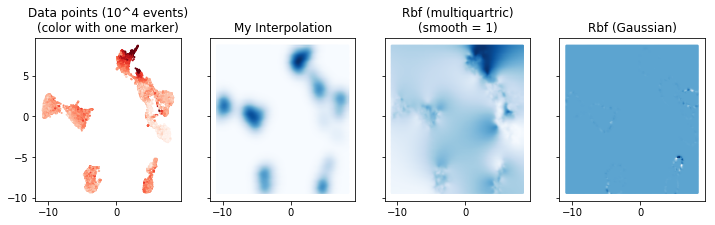

In [196]:
nrow, ncol = 1, 4
idx_marker = 0

fig, axes = plt.subplots(nrow, ncol, figsize = (ncol * 3, nrow * 3), sharex = True, sharey = True)
axes[0].scatter(x = dat_pts[:, 0], y = dat_pts[:, 1], c = value[:, idx_marker], s = 1, cmap = "Reds")
axes[1].scatter(x = dat_grids[:, 0], y = dat_grids[:, 1], c = z_test, s = 2, cmap = "Blues")
axes[2].scatter(x = dat_grids[:, 0], y = dat_grids[:, 1], c = z_c_multiq.ravel(), s = 2, cmap = "Blues")
axes[3].scatter(x = dat_grids[:, 0], y = dat_grids[:, 1], c = z_c_guass.ravel(), s = 2, cmap = "Blues")

axes[0].set_title("Data points (10^4 events)\n(color with one marker)")
axes[1].set_title("My Interpolation")
axes[2].set_title("Rbf (multiquartric)\n(smooth = 1)")
axes[3].set_title("Rbf (Gaussian)")
plt.show()

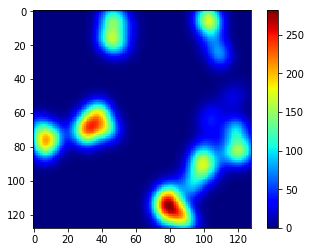

In [202]:
plt.imshow(z_test[:].reshape((128,128)), cmap=plt.cm.jet)
plt.colorbar()
plt.show()

In [175]:
tmp = value[:, idx_marker]
tmp = (tmp - np.min(tmp)) / (np.max(tmp) - np.min(tmp))

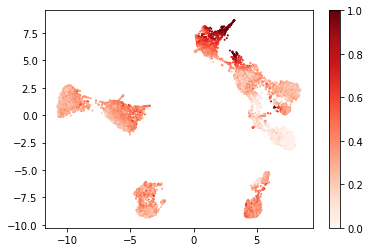

In [176]:

plt.scatter(x = dat_pts[:, 0], y = dat_pts[:, 1], c = tmp, s = 1, cmap = "Reds")
plt.colorbar()
plt.show()